## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import IPython.display as display

In [2]:
from helpers.image_helpers import load_img, tensor_to_image, plot_image, clip_0_1

## Introduction

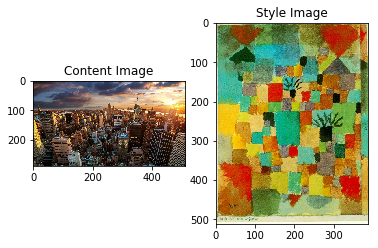

In [3]:
content_image = load_img('../demo_images/content.jpg', max_dim=512)
style_image = load_img('../demo_images/klee_style.jpg', max_dim=512)
result_image = load_img('../output_images/city_kleen_500iter.bmp', max_dim=1024)

plt.subplot(1, 2, 1)
plot_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
plot_image(style_image, 'Style Image')

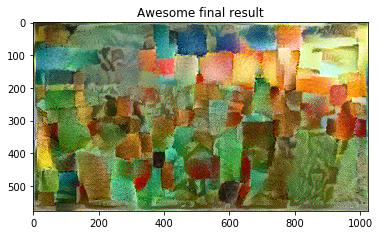

In [4]:
plot_image(result_image, 'Awesome final result')

### El punto de partida: CNN

In [5]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

![alt text](../demo_images/vgg.png "VGG")

In [6]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Los layers de una CNN

In [7]:
layer = 'block2_conv1'

In [8]:
print(vgg.layers[4].name)
vgg.layers[4].weights[0].shape

block2_conv1


TensorShape([3, 3, 64, 128])

![alt text](../demo_images/conv_layer.png "VGG")

Lo que sabemos es que en cada uno de los layers se atiende a distintos aspectos de la imagen. Pero como podemos saber en cual de ellos se atiende al contenido en cuales al estilo.

Lo primero que vamos a hacer es pasar una imagen por la red convolucional y tratar de observar lo que hay a la salida de cada uno de los layers.

Para ello vamos a definir un modelo que devuelva el output de algunos layers:

In [9]:
layers = ['block1_conv1', 'block3_conv1', 'block5_conv2']

In [10]:
outputs = [vgg.get_layer(name).output for name in layers]
model = tf.keras.Model([vgg.input], outputs)

In [11]:
len(model(content_image))

3

In [12]:
layer = model(content_image)

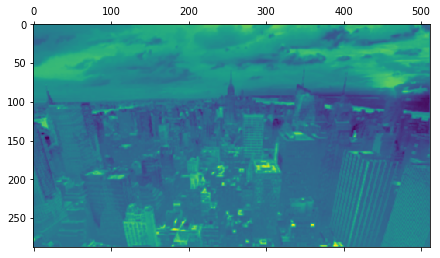

In [13]:
plt.matshow(layer[0][0, :, :, 59])

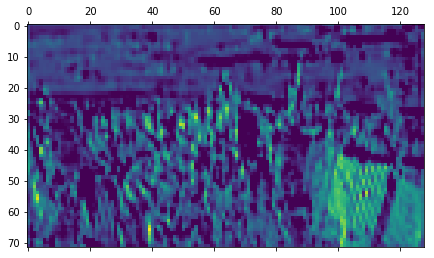

In [14]:
plt.matshow(layer[1][0, :, :, 5])

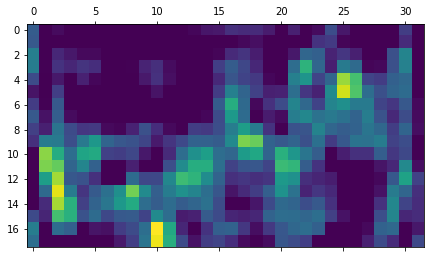

In [15]:
plt.matshow(layer[2][0, :, :, 2])

Se nota que a medida que avazan las capas la red comienza a fijarse en aspectos distintos de la foto.

¿Que layers elegiriais para el contenido de la imagen?

### Como conseguir: el estilo 😎 y el contenido 🤓

Ya hemos elegido nuestro layer de contenido. Como los primeros layers se fijan en aspectos mas globales de la imagen elegiremos un layer de las primeras capas. En el paper recomiendan block1_conv1.

![alt text](../demo_images/capture.jpg "VGG")

Vale, pero con lo que tenemos nos surgen varias preguntas:

Preguntas:
- Como generamos una imagen RGB a partir de un estilo, de un contenido o de ambos?
- Por que utilizamos el mismo layer y el resultado es distinto en contenido y en estilo?
- Como combinamos estas dos técnicas para obtener un mix de imagenes?

Vamos a empezar por definir un modelo que devuelva los layers que le indiquemos:

In [16]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg =  self.__define_vgg_model(style_layers + content_layers)
        self.vgg.trainable = False
        
    def __define_vgg_model(self, layers):
        style_outputs = [vgg.get_layer(name).output for name in self.style_layers]
        content_outputs = [vgg.get_layer(name).output for name in self.content_layers]
        model_outputs = style_outputs + content_outputs
        return tf.keras.Model([vgg.input], model_outputs)
    
    def __gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)


    def call(self, inputs, plot_style=False):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        
        filters = style_outputs
        style_outputs = [self.__gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict, 'filters': filters}

In [17]:
content_layers = ['block1_conv1'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
]

In [18]:
extractor = StyleContentModel(style_layers, content_layers)
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']
filters = extractor(style_image)['filters']

Vamos a analizar la salida de cada uno de los layers que devuelve el modelo:
Aquí encontramos la primera diferencia entre estilo y contenido. El contenido que obtenemos es la salida de cada uno de los filtros de la CNN en la capa indicada (como lo que hemos visualizado antes). Hasta aquí todo claro.

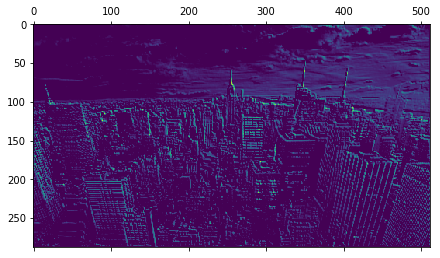

In [19]:
plt.matshow(content_targets['block1_conv1'][0, :, :, 4])

Vemos también que lo que mandamos al metodo gram_matrix que nos devolvera el estilo es de la misma forma que el contenido sacado de la foto anterior, hasta aquí son iguales

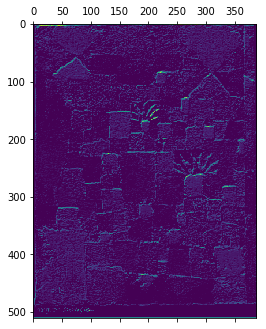

In [20]:
plt.matshow(filters[0][0, :, :, 3])

Vamos a analizar ahora la respuesta del modelo una vez pasado por la Gram Matrix.

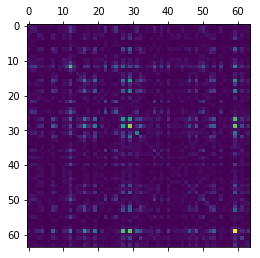

In [21]:
plt.matshow(style_targets['block1_conv1'][0, :, :])

Gram Matrix: Mide la relación entre las imagenes de los distintos filtros

![alt text](../demo_images/gram_matrix.jfif "VGG")

Se puede observar que se ha generado una matriz donde se relaciona la influencia de cada uno de los filtros con los anteriores.
Vale ya tenemos el metodo que nos permite "decantar" el estilo y el contenido de la foto. Pero... como podemos visualizar estos resultados en forma de imagen RGB, que es lo que queremos?

### Un problema de optimización 🛸

Para crear imagenes vamos a utilizar un método de optimización, que nos va a permitir ir editando los valores de los pixels de la foto que queremos modificar para ir adaptandose al target que queramos.

ESQUEMA OPTIMIZACION

Vamos a definirlo, para la optimización vamos a necesitar: un optimizador y una pérdida que nos permita ajustar los pixels de la nueva imagen.

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
def style_content_loss(outputs, content_weight, style_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len([*style_outputs])

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len([*content_outputs])
    loss =  style_loss + content_loss
    return loss

In [24]:
@tf.function()
def train_step(image, content_weight, style_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, content_weight, style_weight)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [25]:
image = tf.Variable(content_image)
white_noise = tf.Variable(tf.random.normal(shape=tf.shape(content_image), mean=0.0, stddev=(50)/(255), dtype=tf.float32))

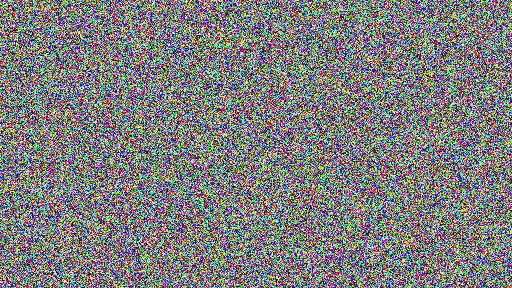

In [26]:
display.display(tensor_to_image(white_noise))

Por último, vamos a fijar la importancia relativa del estilo y el contenido en una foto:

In [27]:
style_weight = 10
content_weight = 1

In [28]:
def optimize_picture(image, train_steps=100, content_weight=1, style_weight=100 ):
    start = time.time()
    for n in range(train_steps):
        train_step(image, content_weight, style_weight)
        print(".", end='')
        if n % 10 == 0:
            display.clear_output(wait=True)
            display.display(tensor_to_image(image))
            print("Train step: {}".format(n))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    return image

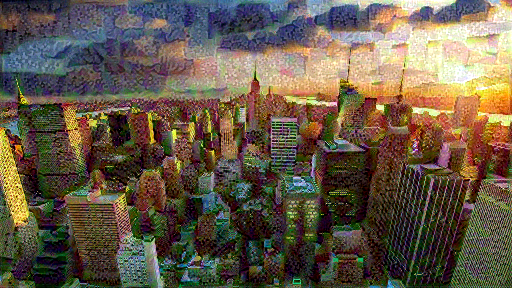

Train step: 10
.........Total time: 76.1


In [29]:
image =  optimize_picture(image, train_steps=20, content_weight=1, style_weight=100 )